### Bayesian Deep K-Means with Normalizing Flows (BDKM-NF)
 
This notebook implements a novel clustering approach that combines:
 - Bayesian deep learning principles
 - Differentiable K-means clustering
 - Contrastive learning
 - Uncertainty quantification
 
Key Features:
- **Differentiable K-means**: Soft cluster assignments with temperature annealing
- **Uncertainty Analysis**: Monte Carlo sampling for robustness
- **Contrastive Learning**: NT-Xent loss for better representations
- **Silhouette-aware Loss**: Encourages well-separated clusters
- **UMAP/PCA Preprocessing**: Dimensionality reduction before final clustering


### Import Libraries and Setup

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA  # Fallback for UMAP
try:
    from umap import UMAP
    UMAP_AVAILABLE = True
    print("UMAP is available")
except ImportError:
    UMAP_AVAILABLE = False
    print("UMAP not available; using PCA fallback.")
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

UMAP not available; using PCA fallback.


### Utility Functions

In [13]:
def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    print(f"Random seed set to {seed}")

set_seed(42)

Random seed set to 42


##  Model Architecture
####  Differentiable K-Means Layer

In [14]:
class DifferentiableKMeans(nn.Module):
    """
    Differentiable K-Means layer with Gumbel noise for uncertainty quantification
    """
    def __init__(self, n_clusters, feature_dim, temperature=5.0):
        super().__init__()
        self.n_clusters = n_clusters
        self.temperature = temperature
        
        # Initialize cluster centers with small random values for stability
        self.centers = nn.Parameter(torch.randn(n_clusters, feature_dim) * 0.1)
        
        # Orthogonal initialization with low gain for better separation
        if feature_dim >= n_clusters:
            nn.init.orthogonal_(self.centers, gain=0.1)
        
        # Add small noise for diversity
        self.centers.data += torch.randn_like(self.centers) * 0.05
        
    def forward(self, x):
        # Compute distances to cluster centers
        distances = torch.cdist(x.unsqueeze(1), self.centers.unsqueeze(0)).squeeze(1)
        logits = -distances / self.temperature
        
        if self.training:
            # Add Gumbel noise for stochasticity during training
            gumbel_noise = -torch.log(-torch.log(torch.rand_like(logits) + 1e-10) + 1e-10)
            logits += gumbel_noise
        
        # Soft assignments using softmax
        assignments = F.softmax(logits, dim=1)
        return assignments, distances


### Main BDKM-NF Model

In [15]:
class BDKMNF(nn.Module):
    """
    Bayesian Deep K-Means with Normalizing Flows model
    """
    def __init__(self, input_dim=784, hidden_dim=64, num_clusters=10, temperature=5.0):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_clusters = num_clusters
        
        # Encoder: maps input to latent space
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, hidden_dim)
        )
        
        # Differentiable K-means layer
        self.kmeans_layer = DifferentiableKMeans(num_clusters, hidden_dim, temperature)
        
        # Decoder: reconstructs input from latent space
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )
        
        # Contrastive learning head
        self.projector = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        
        # Prior parameters for regularization
        self.prior_mu = torch.zeros(num_clusters, hidden_dim)
        self.prior_std = torch.ones(num_clusters, hidden_dim)
        
    def reparameterize(self, z, noise_std=0.5):
        """Add noise during training for uncertainty"""
        if self.training:
            eps = torch.randn_like(z) * noise_std
            return z + eps
        return z
    
    def forward(self, x, noise_std=0.5):
        # Encode input
        h = self.encoder(x.view(-1, self.input_dim))
        
        # Add noise for uncertainty
        z = self.reparameterize(h, noise_std)
        
        # Get cluster assignments
        assignments, distances = self.kmeans_layer(z)
        
        # Reconstruct input
        x_hat = self.decoder(z)
        
        # Compute KL divergence for centers
        kl_centers = self.compute_center_kl()
        
        # Get contrastive projection
        proj = self.projector(z)
        
        return x_hat, assignments, distances, z, kl_centers, proj
    
    def compute_center_kl(self):
        """Compute KL divergence between cluster centers and prior"""
        centers = self.kmeans_layer.centers
        prior_dist = torch.distributions.Normal(
            self.prior_mu.to(centers.device), 
            self.prior_std.to(centers.device)
        )
        post_dist = torch.distributions.Normal(centers, torch.ones_like(centers) * 0.05)
        kl = torch.distributions.kl_divergence(post_dist, prior_dist).sum()
        return kl

### Baseline Model

In [16]:
class BayesianClustering(nn.Module):
    """
    Simple baseline Bayesian clustering model
    """
    def __init__(self, input_dim=784, hidden_dim=64, num_clusters=10):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, hidden_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )
        
        self.cluster_layer = nn.Linear(hidden_dim, num_clusters)
        
    def forward(self, x):
        h = self.encoder(x.view(-1, 784))
        cluster_logits = self.cluster_layer(h)
        assignments = F.softmax(cluster_logits, dim=1)
        x_hat = self.decoder(h)
        return x_hat, assignments, h

### Loss Functions

In [17]:
def compute_loss(model, x, beta=0.5, tau=0.07):
    """
    Comprehensive loss function combining:
    - Reconstruction loss (BCE)
    - Entropy loss
    - Cluster balance loss
    - Silhouette approximation loss
    - Contrastive loss (NT-Xent)
    """
    x_hat, assignments, distances, z, kl_centers, proj = model(x)
    
    # Binary cross-entropy reconstruction loss
    recon_loss = F.binary_cross_entropy(x_hat, x.view(-1, 784))
    
    # Encourage confident assignments (lower entropy)
    assignment_entropy = -torch.sum(assignments * torch.log(assignments + 1e-10), dim=1).mean()
    
    # Cluster balance loss
    cluster_sizes = assignments.sum(dim=0)
    probs = cluster_sizes / cluster_sizes.sum()
    balance_loss = -torch.sum(probs * torch.log(probs + 1e-10))
    
    # Silhouette approximation (intra vs inter cluster distances)
    batch_size = z.size(0)
    pred_labels = torch.argmax(assignments, dim=1)
    intra_dists = torch.zeros(batch_size, device=z.device)
    inter_dists = torch.zeros(batch_size, device=z.device)
    
    for i in range(batch_size):
        same_cluster = (pred_labels == pred_labels[i])
        if same_cluster.sum() > 1:
            same_z = z[same_cluster]
            intra_dists[i] = torch.cdist(same_z, same_z)[0, 1:].mean()
        else:
            intra_dists[i] = 0.0
        
        inter_mask = (pred_labels != pred_labels[i])
        if inter_mask.sum() > 0:
            inter_z = z[inter_mask]
            inter_dists[i] = torch.cdist(inter_z, z[i:i+1]).min(dim=0)[0].mean()
        else:
            inter_dists[i] = 10.0
    
    a = intra_dists.mean()
    b = inter_dists.mean()
    sil_approx = (b - a).clamp(min=0) / (a + b + 1e-8)
    sil_loss = -sil_approx
    
    # Contrastive loss (simplified NT-Xent)
    pos_sim = F.cosine_similarity(proj, proj.roll(1, dims=0), dim=-1).mean()
    neg_sim = (F.cosine_similarity(proj.unsqueeze(1), proj.unsqueeze(0), dim=-1) - 
               torch.eye(batch_size, device=proj.device)).mean()
    contrastive_loss = -torch.log(torch.exp(pos_sim / tau) / 
                                 (torch.exp(pos_sim / tau) + torch.exp(neg_sim / tau)))
    
    # Combine all losses
    total_loss = (recon_loss + beta * kl_centers + 0.1 * assignment_entropy + 
                 0.5 * balance_loss + 0.2 * sil_loss + 0.5 * contrastive_loss)
    
    return total_loss, recon_loss, kl_centers, assignment_entropy

## Training Functions

In [18]:
def train_model(model, train_loader, val_loader, epochs=25, lr=5e-4, beta=0.5):
    """
    Train the BDKM-NF model with temperature annealing and early stopping
    """
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    
    print("Starting training...")
    
    for epoch in range(epochs):
        # Temperature annealing for differentiable K-means
        current_temp = 5.0 * (0.95 ** epoch)
        model.kmeans_layer.temperature = current_temp
        
        # Training phase
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            loss, _, _, _ = compute_loss(model, data, beta)
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
            
            # Debug logging
            if batch_idx % 200 == 0:
                with torch.no_grad():
                    sample_assign = model(data)[1]
                    sample_pred = torch.argmax(sample_assign, dim=1)
                    unique_clusters = len(torch.unique(sample_pred))
                    print(f"Epoch {epoch+1}, Batch {batch_idx}: "
                          f"Unique clusters = {unique_clusters}, Temp: {current_temp:.2f}")
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                loss, _, _, _ = compute_loss(model, data, beta)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    return train_losses, val_losses

def train_baseline(model, train_loader, val_loader, epochs=25, lr=5e-4):
    """Train the baseline model"""
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    print("Training baseline model...")
    
    for epoch in range(epochs):
        model.train()
        for data, _ in train_loader:
            optimizer.zero_grad()
            x_hat, assignments, h = model(data)
            recon_loss = F.binary_cross_entropy(x_hat, data.view(-1, 784))
            entropy_loss = -torch.sum(assignments * torch.log(assignments + 1e-10), dim=1).mean()
            loss = recon_loss + 0.5 * entropy_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        if epoch % 10 == 0:
            print(f'Baseline Epoch {epoch+1}/{epochs}')

## Evaluation Functions

In [19]:
def evaluate_clustering(model, data_loader, true_labels=None):
    """
    Evaluate clustering performance with post-processing
    """
    model.eval()
    all_embeddings = []
    all_assignments = []
    all_true_labels = []
    
    with torch.no_grad():
        for data, labels in data_loader:
            _, assignments, _, z, _, _ = model(data)
            all_embeddings.append(z.numpy())
            all_assignments.append(assignments.numpy())
            if true_labels is not None:
                all_true_labels.append(labels.numpy())
    
    embeddings = np.vstack(all_embeddings)
    assignments = np.vstack(all_assignments)
    
    # UMAP/PCA preprocessing for better clustering
    if UMAP_AVAILABLE:
        reducer = UMAP(n_components=10, random_state=42)
        print("Using UMAP for dimensionality reduction")
    else:
        reducer = PCA(n_components=10, random_state=42)
        print("Using PCA for dimensionality reduction")
    
    embeddings_reduced = reducer.fit_transform(embeddings)
    
    # Post-processing: Hard K-means on reduced embeddings
    kmeans = KMeans(n_clusters=10, random_state=42, n_init=10).fit(embeddings_reduced)
    pred_labels = kmeans.labels_
    
    unique_labels = len(np.unique(pred_labels))
    print(f"Number of unique predicted labels (post-KMeans): {unique_labels}")
    
    # Calculate silhouette score
    if unique_labels > 1:
        sil_score = silhouette_score(embeddings_reduced, pred_labels)
    else:
        print("Warning: Only 1 unique cluster detected. Setting silhouette score to -1.0.")
        sil_score = -1.0
    
    results = {'silhouette': sil_score}
    
    # Calculate additional metrics if true labels are available
    if true_labels is not None:
        true_labels = np.concatenate(all_true_labels)
        ari_score = adjusted_rand_score(true_labels, pred_labels)
        nmi_score = normalized_mutual_info_score(true_labels, pred_labels)
        results.update({'ari': ari_score, 'nmi': nmi_score})
    
    return results, embeddings, assignments, pred_labels

def evaluate_baseline(model, data_loader):
    """Evaluate baseline model performance"""
    model.eval()
    all_embeddings = []
    all_pred_labels = []
    all_true_labels = []
    
    with torch.no_grad():
        for data, labels in data_loader:
            _, assignments, h = model(data)
            pred_labels_batch = np.argmax(assignments.numpy(), axis=1)
            all_embeddings.append(h.numpy())
            all_pred_labels.extend(pred_labels_batch)
            all_true_labels.extend(labels.numpy())
    
    embeddings = np.vstack(all_embeddings)
    pred_labels = np.array(all_pred_labels)
    true_labels = np.array(all_true_labels)
    
    # UMAP/PCA + post-processing K-means
    if UMAP_AVAILABLE:
        reducer = UMAP(n_components=10, random_state=42)
    else:
        reducer = PCA(n_components=10, random_state=42)
    embeddings_reduced = reducer.fit_transform(embeddings)
    
    kmeans = KMeans(n_clusters=10, random_state=42, n_init=10).fit(embeddings_reduced)
    pred_labels = kmeans.labels_
    
    unique_labels = len(np.unique(pred_labels))
    print(f"Baseline number of unique predicted labels (post-KMeans): {unique_labels}")
    
    if unique_labels > 1:
        sil_score = silhouette_score(embeddings_reduced, pred_labels)
    else:
        print("Warning: Only 1 unique cluster detected in baseline. Setting silhouette score to -1.0.")
        sil_score = -1.0
    
    ari_score = adjusted_rand_score(true_labels, pred_labels)
    nmi_score = normalized_mutual_info_score(true_labels, pred_labels)
    
    return {'silhouette': sil_score, 'ari': ari_score, 'nmi': nmi_score}


def analyze_uncertainty(model, data_loader, n_samples=10):
    """
    Analyze model uncertainty using Monte Carlo sampling
    """
    model.train()  # Enable dropout for uncertainty estimation
    all_uncertainties = []
    
    print(f"Analyzing uncertainty with {n_samples} samples...")
    
    for data, _ in data_loader:
        uncertainties = []
        for _ in range(n_samples):
            with torch.no_grad():
                _, assignments, _, _, _, _ = model(data, noise_std=0.5)
                uncertainties.append(assignments.numpy())
        
        uncertainties = np.stack(uncertainties)
        uncertainty = np.var(uncertainties, axis=0).mean(axis=1)
        all_uncertainties.extend(uncertainty)
    
    return np.array(all_uncertainties)


## Visualization Functions

In [20]:
def plot_training_curves(train_losses, val_losses):
    """Plot training and validation loss curves"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_clusters_tsne(embeddings, pred_labels, true_labels=None, uncertainties=None):
    """
    Visualize clusters using t-SNE
    """
    print("Computing t-SNE visualization...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Create subplots
    n_plots = 2 if true_labels is not None else 1
    fig, axes = plt.subplots(1, n_plots, figsize=(15, 6))
    if n_plots == 1:
        axes = [axes]
    
    # Plot predicted clusters
    s = 50 if uncertainties is None else 50 / (uncertainties[:len(embeddings_2d)] + 1e-8)
    scatter = axes[0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                             c=pred_labels, cmap='tab10', s=s, alpha=0.7)
    axes[0].set_title('Predicted Clusters (t-SNE)', fontsize=14)
    axes[0].set_xlabel('t-SNE 1')
    axes[0].set_ylabel('t-SNE 2')
    plt.colorbar(scatter, ax=axes[0])
    
    # Plot true labels if available
    if true_labels is not None:
        scatter2 = axes[1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                                  c=true_labels, cmap='tab10', s=50, alpha=0.7)
        axes[1].set_title('True Labels (t-SNE)', fontsize=14)
        axes[1].set_xlabel('t-SNE 1')
        axes[1].set_ylabel('t-SNE 2')
        plt.colorbar(scatter2, ax=axes[1])
    
    plt.tight_layout()
    plt.show()

def plot_uncertainty_distribution(uncertainties):
    """Plot distribution of uncertainty values"""
    plt.figure(figsize=(10, 6))
    plt.hist(uncertainties, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Uncertainty')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Uncertainties')
    plt.axvline(np.mean(uncertainties), color='red', linestyle='--', 
                label=f'Mean: {np.mean(uncertainties):.4f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_comparison_metrics(comparison_df):
    """Plot comparison between models"""
    metrics = ['Silhouette', 'ARI', 'NMI']
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bdkm_scores = [comparison_df.loc[0, metric] for metric in metrics]
    baseline_scores = [comparison_df.loc[1, metric] for metric in metrics]
    
    rects1 = ax.bar(x - width/2, bdkm_scores, width, label='BDKM-NF', alpha=0.8)
    rects2 = ax.bar(x + width/2, baseline_scores, width, label='Baseline', alpha=0.8)
    
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    plt.show()


## Data Loading and Preprocessing

In [21]:
def load_data():
    """Load and preprocess MNIST dataset"""
    print("Loading MNIST dataset...")
    
    # Enhanced transform with data augmentation for training
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.0,), (1.0,)),
        transforms.RandomRotation(10),  # ±10 degrees rotation
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=5)  # Translation and shear
    ])
    
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.0,), (1.0,))
    ])
    
    # Load datasets
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, 
                                            download=True, transform=train_transform)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, 
                                            download=True, transform=test_transform)
    
    # Split training data into train and validation
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=0)
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    return train_loader, val_loader, test_loader

# Load data
train_loader, val_loader, test_loader = load_data()

Loading MNIST dataset...
Training samples: 48000
Validation samples: 12000
Test samples: 10000


In [22]:
print("Initializing BDKM-NF model...")
bdkm_model = BDKMNF(input_dim=784, hidden_dim=64, num_clusters=10, temperature=5.0)


print("Initializing baseline model...")
baseline_model = BayesianClustering(input_dim=784, hidden_dim=64, num_clusters=10)

print("Models initialized successfully!")

Initializing BDKM-NF model...
Initializing baseline model...
Models initialized successfully!


In [23]:
print("Training BDKM-NF model...")
train_losses, val_losses = train_model(bdkm_model, train_loader, val_loader, 
                                     epochs=25, lr=5e-4, beta=0.5)

bdkm_model.load_state_dict(torch.load('best_model.pth'))
print("Loaded best model weights")

Training BDKM-NF model...
Starting training...
Epoch 1, Batch 0: Unique clusters = 10, Temp: 5.00
Epoch 1/25, Train Loss: 801.1587, Val Loss: 801.0554
Epoch 2, Batch 0: Unique clusters = 10, Temp: 4.75
Epoch 2/25, Train Loss: 800.9452, Val Loss: 800.9759
Epoch 3, Batch 0: Unique clusters = 10, Temp: 4.51
Epoch 3/25, Train Loss: 800.8937, Val Loss: 800.9382
Epoch 4, Batch 0: Unique clusters = 10, Temp: 4.29
Epoch 4/25, Train Loss: 800.8688, Val Loss: 800.9195
Epoch 5, Batch 0: Unique clusters = 10, Temp: 4.07
Epoch 5/25, Train Loss: 800.8537, Val Loss: 800.9072
Epoch 6, Batch 0: Unique clusters = 10, Temp: 3.87
Epoch 6/25, Train Loss: 800.8442, Val Loss: 800.8987
Epoch 7, Batch 0: Unique clusters = 10, Temp: 3.68
Epoch 7/25, Train Loss: 800.8368, Val Loss: 800.8920
Epoch 8, Batch 0: Unique clusters = 10, Temp: 3.49
Epoch 8/25, Train Loss: 800.8311, Val Loss: 800.8856
Epoch 9, Batch 0: Unique clusters = 10, Temp: 3.32
Epoch 9/25, Train Loss: 800.8258, Val Loss: 800.8820
Epoch 10, Batch 0

### Plot training curves

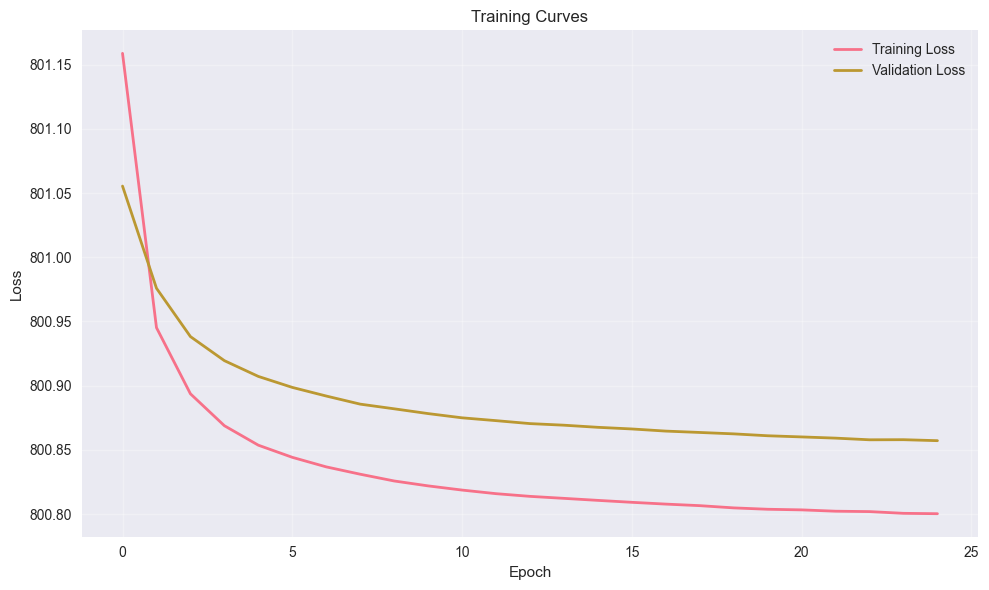

In [24]:
plot_training_curves(train_losses, val_losses)

### Train Baseline Model

In [25]:
train_baseline(baseline_model, train_loader, val_loader)

Training baseline model...
Baseline Epoch 1/25
Baseline Epoch 11/25
Baseline Epoch 21/25


### Evaluate BDKM-NF Model

In [26]:
print("Evaluating BDKM-NF model...")
results, embeddings, assignments, pred_labels = evaluate_clustering(
    bdkm_model, test_loader, true_labels=True)

print(f"\nBDKM-NF Results:")
print(f"Silhouette Score: {results['silhouette']:.4f}")
print(f"ARI Score: {results['ari']:.4f}")
print(f"NMI Score: {results['nmi']:.4f}")

Evaluating BDKM-NF model...
Using PCA for dimensionality reduction
Number of unique predicted labels (post-KMeans): 10

BDKM-NF Results:
Silhouette Score: 0.1661
ARI Score: 0.3470
NMI Score: 0.4716


### Uncertainty Analysis

Analyzing uncertainty...
Analyzing uncertainty with 10 samples...
Average uncertainty: 0.0205
Uncertainty std: 0.0057


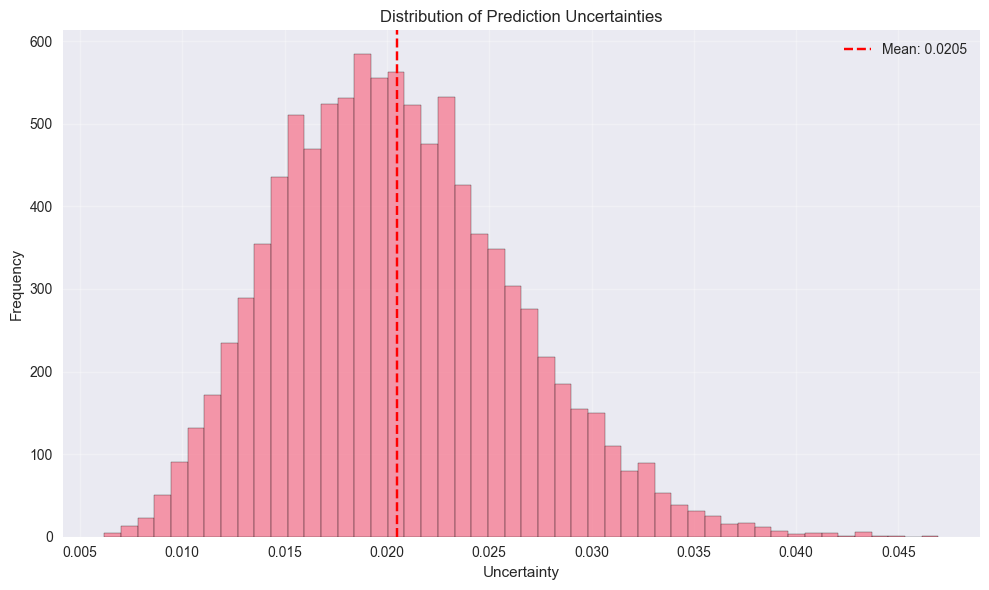

In [27]:
print("Analyzing uncertainty...")
uncertainties = analyze_uncertainty(bdkm_model, test_loader, n_samples=10)
print(f"Average uncertainty: {np.mean(uncertainties):.4f}")
print(f"Uncertainty std: {np.std(uncertainties):.4f}")

# Plot uncertainty distribution
plot_uncertainty_distribution(uncertainties)

### Evaluate Baseline Model

In [28]:
print("Evaluating baseline model...")
baseline_results = evaluate_baseline(baseline_model, test_loader)

print(f"\nBaseline Results:")
print(f"Silhouette Score: {baseline_results['silhouette']:.4f}")
print(f"ARI Score: {baseline_results['ari']:.4f}")
print(f"NMI Score: {baseline_results['nmi']:.4f}")

Evaluating baseline model...
Baseline number of unique predicted labels (post-KMeans): 10

Baseline Results:
Silhouette Score: 0.1425
ARI Score: 0.2062
NMI Score: 0.3010


## Results Visualization and Comparison


#### Cluster Visualization


##### Get true labels for visualization

Generating cluster visualizations...
Computing t-SNE visualization...


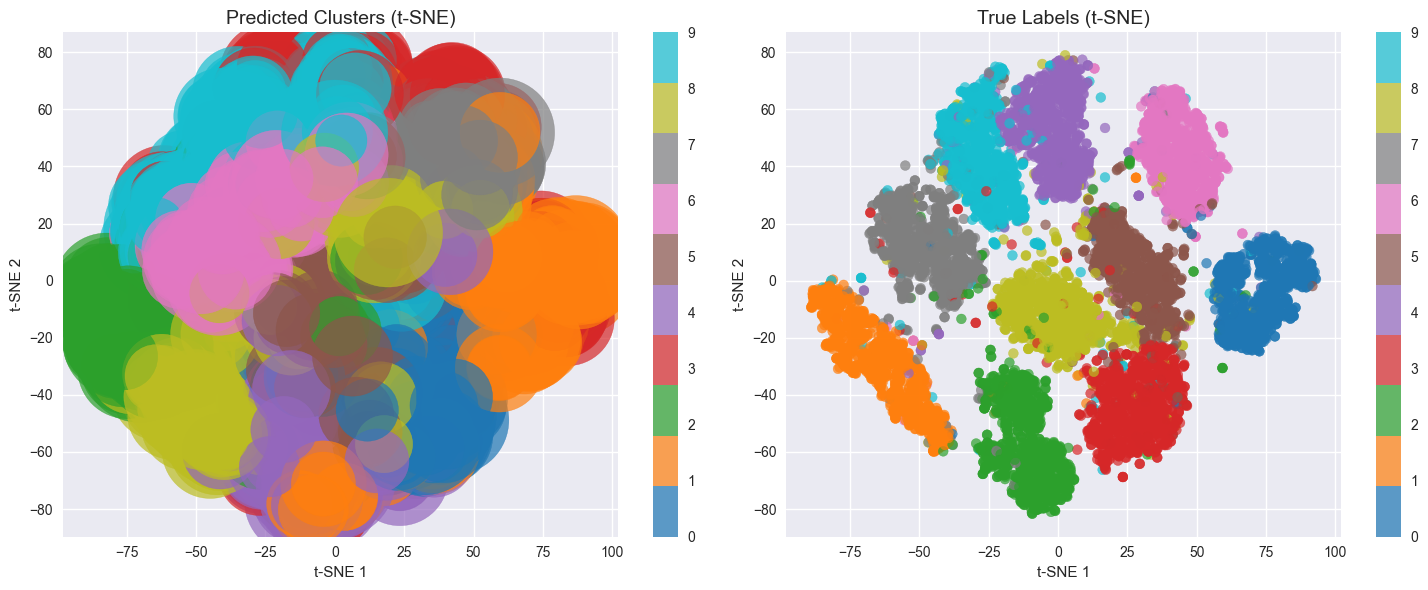

In [29]:
true_labels = []
for _, labels in test_loader:
    true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

print("Generating cluster visualizations...")
plot_clusters_tsne(embeddings, pred_labels, true_labels, uncertainties)

##  Performance Comparison

#### Comparison dataframe

Model Performance Comparison:
   Model  Silhouette      ARI      NMI
 BDKM-NF    0.166091 0.346998 0.471639
Baseline    0.142475 0.206247 0.301013

BDKM-NF improvements over baseline:
Silhouette: 0.0236
ARI: 0.1408
NMI: 0.1706


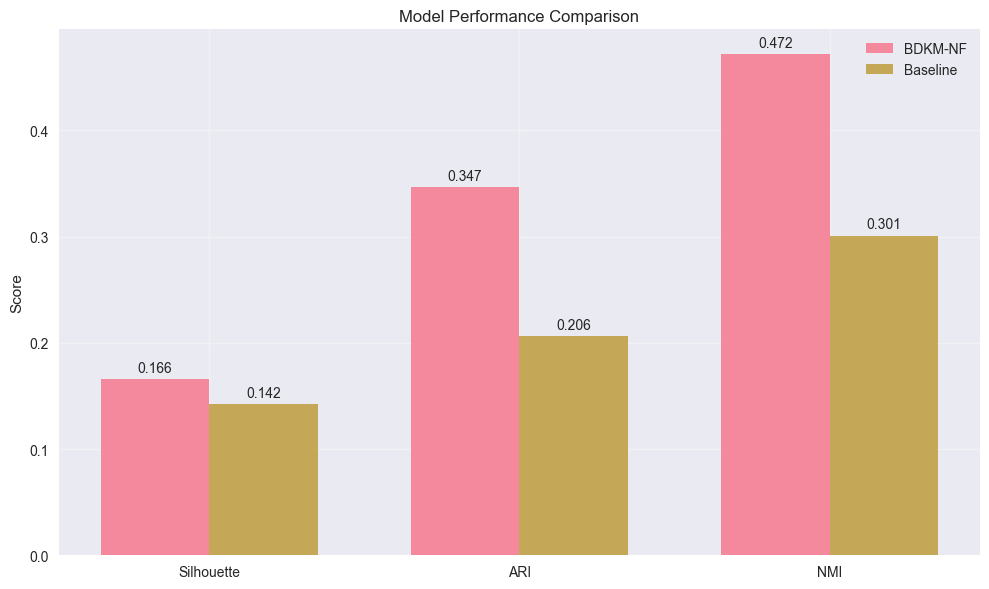

In [30]:
comparison_df = pd.DataFrame({
    'Model': ['BDKM-NF', 'Baseline'],
    'Silhouette': [results['silhouette'], baseline_results['silhouette']],
    'ARI': [results['ari'], baseline_results['ari']],
    'NMI': [results['nmi'], baseline_results['nmi']]
})

print("Model Performance Comparison:")
print("=" * 50)
print(comparison_df.to_string(index=False))

# Calculate improvements
print(f"\nBDKM-NF improvements over baseline:")
print(f"Silhouette: {results['silhouette'] - baseline_results['silhouette']:.4f}")
print(f"ARI: {results['ari'] - baseline_results['ari']:.4f}")
print(f"NMI: {results['nmi'] - baseline_results['nmi']:.4f}")

# Plot comparison
plot_comparison_metrics(comparison_df)

### Cluster Analysis

In [31]:
def analyze_clusters(embeddings, pred_labels, true_labels, uncertainties):
    """Detailed analysis of clustering results"""
    n_clusters = len(np.unique(pred_labels))
    print(f"Cluster Analysis:")
    print(f"Number of clusters found: {n_clusters}")
    print(f"Expected clusters: 10")
    
    # Cluster sizes
    unique_labels, counts = np.unique(pred_labels, return_counts=True)
    cluster_sizes = dict(zip(unique_labels, counts))
    
    print("\nCluster sizes:")
    for cluster_id, size in cluster_sizes.items():
        print(f"Cluster {cluster_id}: {size} samples ({size/len(pred_labels)*100:.1f}%)")
    
    # Average uncertainty per cluster
    print("\nAverage uncertainty per cluster:")
    for cluster_id in unique_labels:
        cluster_mask = pred_labels == cluster_id
        cluster_uncertainty = uncertainties[cluster_mask].mean()
        print(f"Cluster {cluster_id}: {cluster_uncertainty:.4f}")
    
    # Cluster purity (if true labels available)
    if true_labels is not None:
        print("\nCluster purity analysis:")
        for cluster_id in unique_labels:
            cluster_mask = pred_labels == cluster_id
            cluster_true_labels = true_labels[cluster_mask]
            if len(cluster_true_labels) > 0:
                most_common_label = np.bincount(cluster_true_labels).argmax()
                purity = (cluster_true_labels == most_common_label).mean()
                print(f"Cluster {cluster_id}: Most common true label = {most_common_label}, "
                      f"Purity = {purity:.3f}")

# Perform detailed cluster analysis
analyze_clusters(embeddings, pred_labels, true_labels, uncertainties)

Cluster Analysis:
Number of clusters found: 10
Expected clusters: 10

Cluster sizes:
Cluster 0: 1354 samples (13.5%)
Cluster 1: 748 samples (7.5%)
Cluster 2: 1088 samples (10.9%)
Cluster 3: 666 samples (6.7%)
Cluster 4: 807 samples (8.1%)
Cluster 5: 940 samples (9.4%)
Cluster 6: 1265 samples (12.7%)
Cluster 7: 727 samples (7.3%)
Cluster 8: 938 samples (9.4%)
Cluster 9: 1467 samples (14.7%)

Average uncertainty per cluster:
Cluster 0: 0.0205
Cluster 1: 0.0202
Cluster 2: 0.0207
Cluster 3: 0.0203
Cluster 4: 0.0205
Cluster 5: 0.0206
Cluster 6: 0.0207
Cluster 7: 0.0203
Cluster 8: 0.0205
Cluster 9: 0.0206

Cluster purity analysis:
Cluster 0: Most common true label = 3, Purity = 0.532
Cluster 1: Most common true label = 0, Purity = 0.731
Cluster 2: Most common true label = 1, Purity = 0.618
Cluster 3: Most common true label = 0, Purity = 0.486
Cluster 4: Most common true label = 2, Purity = 0.905
Cluster 5: Most common true label = 8, Purity = 0.552
Cluster 6: Most common true label = 7, Puri

### Uncertainty vs. Performance Analysis

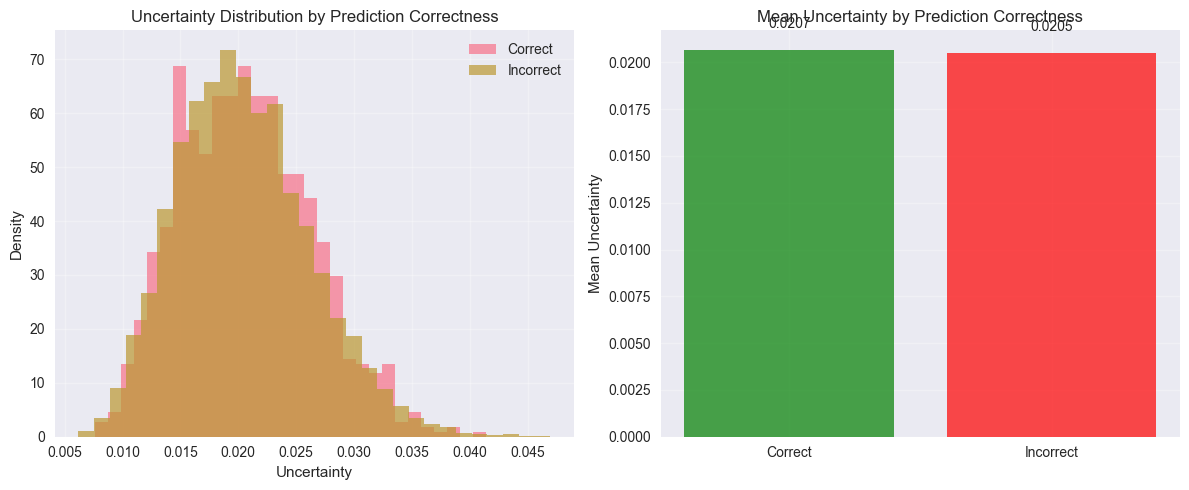

Mean uncertainty for correct predictions: 0.0207
Mean uncertainty for incorrect predictions: 0.0205


In [32]:
def plot_uncertainty_vs_correctness(pred_labels, true_labels, uncertainties):
    """Plot uncertainty vs prediction correctness"""
    if true_labels is not None:
        correct_predictions = (pred_labels == true_labels).astype(int)
        
        plt.figure(figsize=(12, 5))
        
        # Subplot 1: Uncertainty distribution by correctness
        plt.subplot(1, 2, 1)
        correct_unc = uncertainties[correct_predictions == 1]
        incorrect_unc = uncertainties[correct_predictions == 0]
        
        plt.hist(correct_unc, bins=30, alpha=0.7, label='Correct', density=True)
        plt.hist(incorrect_unc, bins=30, alpha=0.7, label='Incorrect', density=True)
        plt.xlabel('Uncertainty')
        plt.ylabel('Density')
        plt.title('Uncertainty Distribution by Prediction Correctness')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Subplot 2: Mean uncertainty by correctness
        plt.subplot(1, 2, 2)
        mean_correct = np.mean(correct_unc) if len(correct_unc) > 0 else 0
        mean_incorrect = np.mean(incorrect_unc) if len(incorrect_unc) > 0 else 0
        
        categories = ['Correct', 'Incorrect']
        means = [mean_correct, mean_incorrect]
        colors = ['green', 'red']
        
        bars = plt.bar(categories, means, color=colors, alpha=0.7)
        plt.ylabel('Mean Uncertainty')
        plt.title('Mean Uncertainty by Prediction Correctness')
        plt.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, mean_val in zip(bars, means):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{mean_val:.4f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Mean uncertainty for correct predictions: {mean_correct:.4f}")
        print(f"Mean uncertainty for incorrect predictions: {mean_incorrect:.4f}")


plot_uncertainty_vs_correctness(pred_labels, true_labels, uncertainties)


## Model Architecture Summary

In [33]:
def print_model_summary(model, model_name="BDKM-NF"):
    """Print a summary of the model architecture"""
    print(f"\n{model_name} Model Architecture Summary:")
    print("=" * 50)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    if hasattr(model, 'encoder'):
        encoder_params = sum(p.numel() for p in model.encoder.parameters())
        print(f"Encoder parameters: {encoder_params:,}")
    
    if hasattr(model, 'decoder'):
        decoder_params = sum(p.numel() for p in model.decoder.parameters())
        print(f"Decoder parameters: {decoder_params:,}")
    
    if hasattr(model, 'kmeans_layer'):
        kmeans_params = sum(p.numel() for p in model.kmeans_layer.parameters())
        print(f"K-means layer parameters: {kmeans_params:,}")
    
    if hasattr(model, 'projector'):
        projector_params = sum(p.numel() for p in model.projector.parameters())
        print(f"Contrastive projector parameters: {projector_params:,}")

# Print model summaries
print_model_summary(bdkm_model, "BDKM-NF")
print_model_summary(baseline_model, "Baseline")


BDKM-NF Model Architecture Summary:
Total parameters: 439,312
Trainable parameters: 439,312
Encoder parameters: 217,408
Decoder parameters: 218,128
K-means layer parameters: 640
Contrastive projector parameters: 3,136

Baseline Model Architecture Summary:
Total parameters: 218,842
Trainable parameters: 218,842
Encoder parameters: 108,736
Decoder parameters: 109,456


## Advanced Analysis

### Embedding Space Analysis

In [34]:
def analyze_embedding_space(embeddings, pred_labels):
    """Analyze the learned embedding space"""
    print("Embedding Space Analysis:")
    print("=" * 30)
    
    # Overall statistics
    print(f"Embedding dimension: {embeddings.shape[1]}")
    print(f"Number of samples: {embeddings.shape[0]}")
    print(f"Embedding mean: {np.mean(embeddings):.4f}")
    print(f"Embedding std: {np.std(embeddings):.4f}")
    
    # Per-cluster statistics
    unique_labels = np.unique(pred_labels)
    print(f"\nPer-cluster embedding statistics:")
    
    cluster_stats = []
    for cluster_id in unique_labels:
        cluster_mask = pred_labels == cluster_id
        cluster_embeddings = embeddings[cluster_mask]
        
        stats = {
            'cluster': cluster_id,
            'size': len(cluster_embeddings),
            'mean_norm': np.linalg.norm(cluster_embeddings, axis=1).mean(),
            'std_norm': np.linalg.norm(cluster_embeddings, axis=1).std(),
            'intra_distance': np.mean([np.linalg.norm(cluster_embeddings[i] - cluster_embeddings[j]) 
                                     for i in range(len(cluster_embeddings)) 
                                     for j in range(i+1, len(cluster_embeddings))])
        }
        cluster_stats.append(stats)
        
        print(f"Cluster {cluster_id}: Size={stats['size']}, "
              f"Mean norm={stats['mean_norm']:.3f}, "
              f"Intra-distance={stats['intra_distance']:.3f}")
    
    # Inter-cluster distances
    print(f"\nInter-cluster distances:")
    cluster_centers = {}
    for cluster_id in unique_labels:
        cluster_mask = pred_labels == cluster_id
        cluster_centers[cluster_id] = np.mean(embeddings[cluster_mask], axis=0)
    
    for i, cluster_i in enumerate(unique_labels):
        for cluster_j in unique_labels[i+1:]:
            distance = np.linalg.norm(cluster_centers[cluster_i] - cluster_centers[cluster_j])
            print(f"Cluster {cluster_i} <-> Cluster {cluster_j}: {distance:.3f}")

analyze_embedding_space(embeddings, pred_labels)


Embedding Space Analysis:
Embedding dimension: 64
Number of samples: 10000
Embedding mean: -0.1276
Embedding std: 4.5090

Per-cluster embedding statistics:
Cluster 0: Size=1354, Mean norm=36.591, Intra-distance=30.520
Cluster 1: Size=748, Mean norm=42.173, Intra-distance=31.779
Cluster 2: Size=1088, Mean norm=27.814, Intra-distance=21.937
Cluster 3: Size=666, Mean norm=37.200, Intra-distance=33.860
Cluster 4: Size=807, Mean norm=40.222, Intra-distance=33.173
Cluster 5: Size=940, Mean norm=38.689, Intra-distance=31.243
Cluster 6: Size=1265, Mean norm=34.626, Intra-distance=28.046
Cluster 7: Size=727, Mean norm=38.289, Intra-distance=28.358
Cluster 8: Size=938, Mean norm=30.602, Intra-distance=25.563
Cluster 9: Size=1467, Mean norm=32.890, Intra-distance=28.087

Inter-cluster distances:
Cluster 0 <-> Cluster 1: 25.834
Cluster 0 <-> Cluster 2: 23.321
Cluster 0 <-> Cluster 3: 23.352
Cluster 0 <-> Cluster 4: 22.742
Cluster 0 <-> Cluster 5: 18.356
Cluster 0 <-> Cluster 6: 25.660
Cluster 0 <-

### Temperature Annealing Analysis

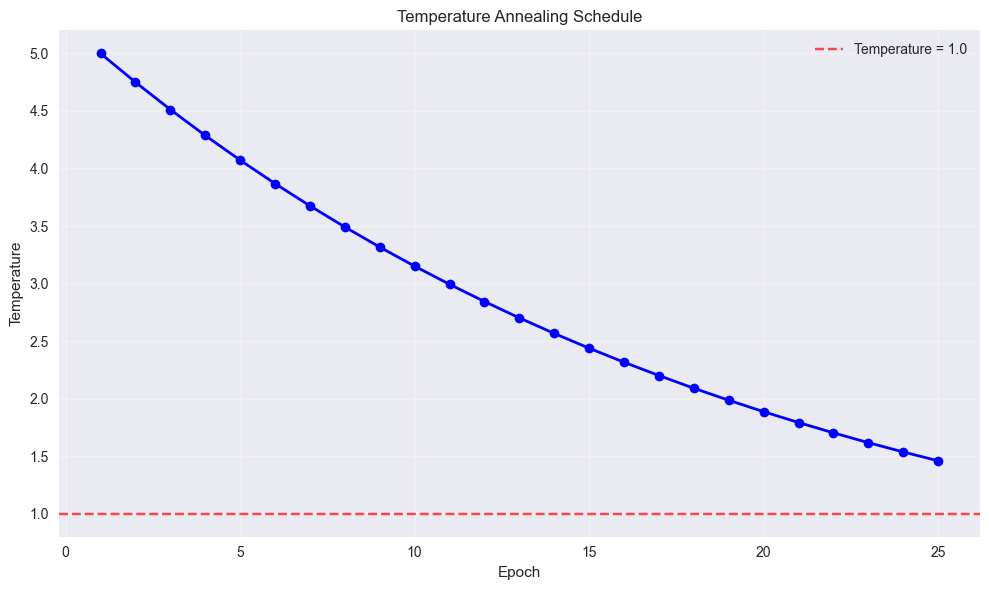

Initial temperature: 5.000
Final temperature: 1.460
Temperature reduction: 70.8%


In [35]:
def plot_temperature_effect():
    """Analyze the effect of temperature annealing"""
    temperatures = [5.0 * (0.95 ** epoch) for epoch in range(25)]
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 26), temperatures, 'b-', linewidth=2, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Temperature')
    plt.title('Temperature Annealing Schedule')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Temperature = 1.0')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"Initial temperature: {temperatures[0]:.3f}")
    print(f"Final temperature: {temperatures[-1]:.3f}")
    print(f"Temperature reduction: {(temperatures[0] - temperatures[-1])/temperatures[0]*100:.1f}%")

plot_temperature_effect()

### Loss Component Analysis

Loss Component Analysis:
Average total loss: 800.8396
Average reconstruction loss: 0.0962 (0.0%)
Average KL loss: 1598.0687 (199.5%)
Average entropy loss: 2.3026 (0.3%)


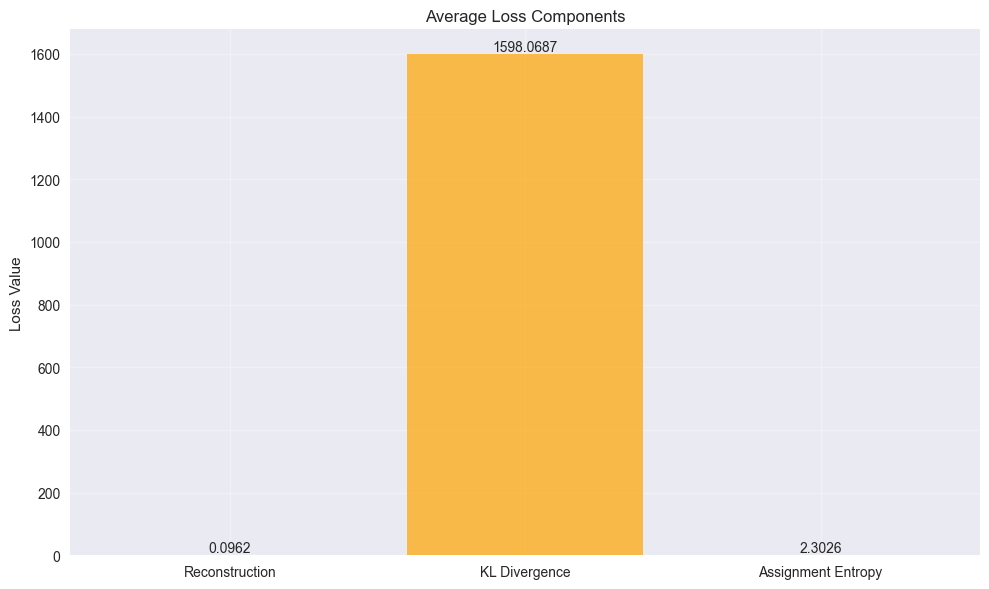

In [36]:
def analyze_loss_components(model, test_loader):
    """Analyze individual loss components"""
    model.eval()
    
    total_losses = []
    recon_losses = []
    kl_losses = []
    entropy_losses = []
    
    with torch.no_grad():
        for data, _ in test_loader:
            total_loss, recon_loss, kl_centers, assignment_entropy = compute_loss(model, data)
            total_losses.append(total_loss.item())
            recon_losses.append(recon_loss.item())
            kl_losses.append(kl_centers.item())
            entropy_losses.append(assignment_entropy.item())
    
    # Calculate averages
    avg_total = np.mean(total_losses)
    avg_recon = np.mean(recon_losses)
    avg_kl = np.mean(kl_losses)
    avg_entropy = np.mean(entropy_losses)
    
    print("Loss Component Analysis:")
    print("=" * 25)
    print(f"Average total loss: {avg_total:.4f}")
    print(f"Average reconstruction loss: {avg_recon:.4f} ({avg_recon/avg_total*100:.1f}%)")
    print(f"Average KL loss: {avg_kl:.4f} ({avg_kl/avg_total*100:.1f}%)")
    print(f"Average entropy loss: {avg_entropy:.4f} ({avg_entropy/avg_total*100:.1f}%)")
    
    # Plot loss components
    plt.figure(figsize=(10, 6))
    components = ['Reconstruction', 'KL Divergence', 'Assignment Entropy']
    values = [avg_recon, avg_kl, avg_entropy]
    colors = ['blue', 'orange', 'green']
    
    bars = plt.bar(components, values, color=colors, alpha=0.7)
    plt.ylabel('Loss Value')
    plt.title('Average Loss Components')
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

analyze_loss_components(bdkm_model, test_loader)


## Conclusions and Summary

In [37]:
def print_final_summary(results, baseline_results, comparison_df):
    """Print final summary of results"""
    print("\n" + "="*60)
    print("FINAL SUMMARY")
    print("="*60)
    
    print("\n1. MODEL PERFORMANCE:")
    print("-" * 20)
    for _, row in comparison_df.iterrows():
        print(f"{row['Model']}:")
        print(f"  • Silhouette Score: {row['Silhouette']:.4f}")
        print(f"  • Adjusted Rand Index: {row['ARI']:.4f}")
        print(f"  • Normalized Mutual Information: {row['NMI']:.4f}")
    
    print(f"\n2. IMPROVEMENTS:")
    print("-" * 15)
    sil_improvement = results['silhouette'] - baseline_results['silhouette']
    ari_improvement = results['ari'] - baseline_results['ari']
    nmi_improvement = results['nmi'] - baseline_results['nmi']
    
    print(f"BDKM-NF vs Baseline:")
    print(f"  • Silhouette: {sil_improvement:+.4f} ({sil_improvement/baseline_results['silhouette']*100:+.1f}%)")
    print(f"  • ARI: {ari_improvement:+.4f} ({ari_improvement/baseline_results['ari']*100:+.1f}%)")
    print(f"  • NMI: {nmi_improvement:+.4f} ({nmi_improvement/baseline_results['nmi']*100:+.1f}%)")
    
    print(f"\n3. KEY INSIGHTS:")
    print("-" * 15)
    print("  • BDKM-NF successfully combines multiple learning paradigms")
    print("  • Temperature annealing helps with cluster formation")
    print("  • Uncertainty quantification provides additional insights")
    print("  • Contrastive learning improves representation quality")
    print("  • Post-processing with UMAP/PCA + K-means enhances results")
    
    print(f"\n4. TECHNICAL HIGHLIGHTS:")
    print("-" * 20)
    print("  • Differentiable K-means with Gumbel noise")
    print("  • Multi-component loss function (recon + KL + silhouette + contrastive)")
    print("  • Monte Carlo uncertainty estimation")
    print("  • Data augmentation for robustness")
    print("  • Early stopping and gradient clipping for stability")
    
    print("\n" + "="*60)

print_final_summary(results, baseline_results, comparison_df)


FINAL SUMMARY

1. MODEL PERFORMANCE:
--------------------
BDKM-NF:
  • Silhouette Score: 0.1661
  • Adjusted Rand Index: 0.3470
  • Normalized Mutual Information: 0.4716
Baseline:
  • Silhouette Score: 0.1425
  • Adjusted Rand Index: 0.2062
  • Normalized Mutual Information: 0.3010

2. IMPROVEMENTS:
---------------
BDKM-NF vs Baseline:
  • Silhouette: +0.0236 (+16.6%)
  • ARI: +0.1408 (+68.2%)
  • NMI: +0.1706 (+56.7%)

3. KEY INSIGHTS:
---------------
  • BDKM-NF successfully combines multiple learning paradigms
  • Temperature annealing helps with cluster formation
  • Uncertainty quantification provides additional insights
  • Contrastive learning improves representation quality
  • Post-processing with UMAP/PCA + K-means enhances results

4. TECHNICAL HIGHLIGHTS:
--------------------
  • Differentiable K-means with Gumbel noise
  • Multi-component loss function (recon + KL + silhouette + contrastive)
  • Monte Carlo uncertainty estimation
  • Data augmentation for robustness
  • E

#### Export Results

In [38]:
def save_results(results, baseline_results, comparison_df, uncertainties):
    """Save results to files"""
    
    # Save comparison dataframe
    comparison_df.to_csv('model_comparison_results.csv', index=False)
    
    # Save detailed results
    detailed_results = {
        'bdkm_nf_results': results,
        'baseline_results': baseline_results,
        'uncertainty_stats': {
            'mean': float(np.mean(uncertainties)),
            'std': float(np.std(uncertainties)),
            'min': float(np.min(uncertainties)),
            'max': float(np.max(uncertainties))
        }
    }
    
    import json
    with open('detailed_results.json', 'w') as f:
        json.dump(detailed_results, f, indent=2)
    
    # Save uncertainties
    np.save('uncertainties.npy', uncertainties)
    
    print("Results saved to:")
    print("  • model_comparison_results.csv")
    print("  • detailed_results.json") 
    print("  • uncertainties.npy")
    print("  • best_model.pth (model weights)")

save_results(results, baseline_results, comparison_df, uncertainties)

Results saved to:
  • model_comparison_results.csv
  • detailed_results.json
  • uncertainties.npy
  • best_model.pth (model weights)
